# Sql connect with python

In [ ]:

import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommers'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Admin/Desktop/E-Commers-w'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Sql connection query

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="root",
                            database="ecommers")

cur=db.cursor()


                            

# 1. List all unique cities where customers are located.

In [31]:
query="""select distinct customer_city from customers """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Customer_city"])
df.head(5)

,Customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query="""select count(order_id)  from orders where year(order_purchase_timestamp)= 2017"""

cur.execute(query)

data=cur.fetchall()

"total orders placed in 2017" ,data[0][0]

('total orders placed in 2017', 135303)

# 3 Find the total sales per category.

In [20]:
quary=""" select upper(products.product_category) cotegory , round(sum(payments.payment_value),2)  py_value  from products
join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by cotegory """

cur.execute(quary)

data=cur.fetchall()

data
             

df=pd.DataFrame(data,columns=["Category","Sales"])
df.head(3)

,Category,Sales
0,PERFUMERY,9121295.88
1,FURNITURE DECORATION,25743175.05
2,TELEPHONY,8763876.91


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select sum( case when payment_installments>=1 then 1
    else 0 end ) /count(*) *100
    from payments
"""

cur.execute(query)

data=cur.fetchall()

"The precentage of drders that were paid in installments ", data[0][0]

('The precentage of drders that were paid in installments ',
 Decimal('99.9981'))

# 5. Count the number of customers from each state.

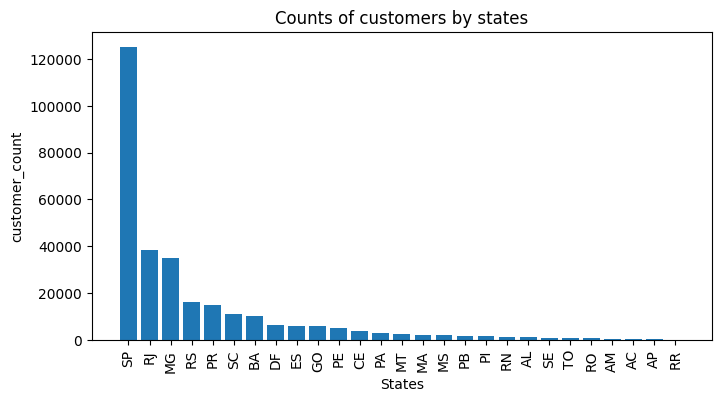

In [23]:
query =""" select customer_state ,count(customer_id) from customers
group by customer_state
"""
cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["State","Customer_count"])

df=df.sort_values(by = "Customer_count", ascending =False)
plt.figure(figsize =(8,4))
plt.bar(df["State"],df["Customer_count"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("customer_count")
plt.title("Counts of customers by states")
plt.show()

In [ ]:
import pandas as pd
import mysql.connector
import os

# 6 Calculate the number of orders per month in 2018.

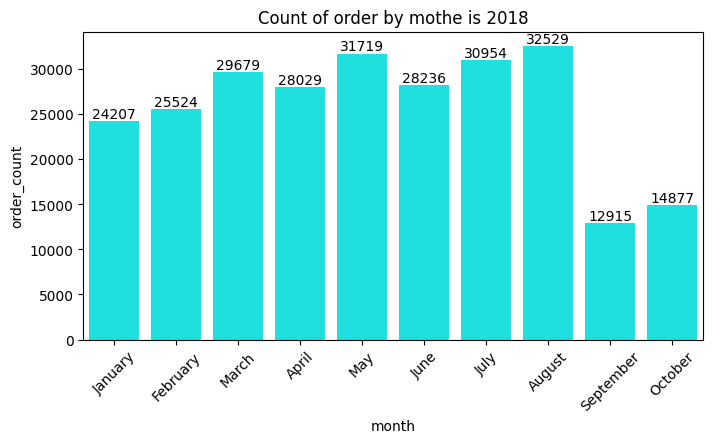

In [27]:
query=""" 
select monthname(order_purchase_timestamp) month ,count(order_id) order_count from orders where year(order_purchase_timestamp)
group by month order by month asc
"""

cur.execute(query)
data=cur.fetchall()
plt.figure(figsize = (8,4))
df=pd.DataFrame(data,columns=["month","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
ax= sns.barplot(x="month", y="order_count", data=df,order=o,color="aqua")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by mothe is 2018")

plt.show()

# data

# 7. Find the average number of products per order, grouped by customer city.

In [28]:
query="""
with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id)  oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_order desc
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer city","Average products"])
df.head(4)


,Customer city,Average products
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [49]:
query="""
select upper(products.product_category) category ,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales desc
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Percentage distribution"] )
df.head(5)

,Category,Percentage distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [54]:
query="""select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Categoty","Order_count","Price"])

arr1=df["Order_count"]
arr2=df["Price"]

np.corrcoef([arr1,arr2])



array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.


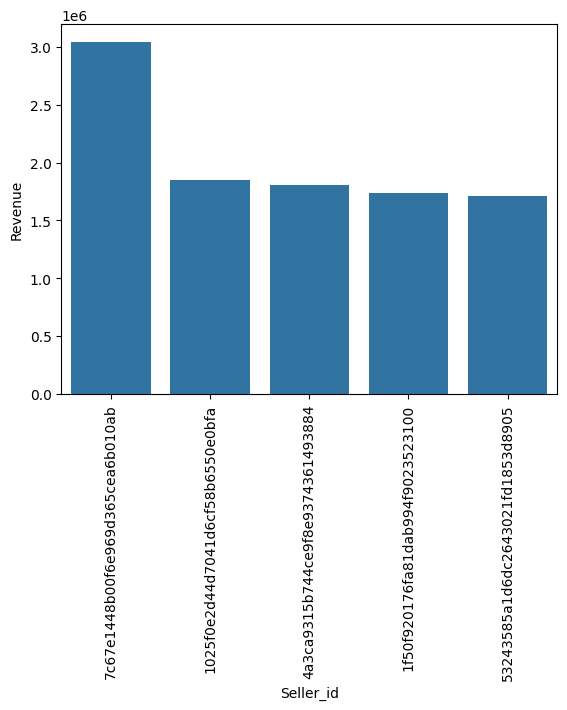

In [12]:
query = """ 

select * ,dense_rank() over (order by revenue desc) as rank_value from 
(select order_items.seller_id ,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])
df=df.head()
br=sns.barplot(x="Seller_id",y="Revenue", data =df)
plt.xticks(rotation=90)
# plt.bar_label(br.containers[0])
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.


In [3]:
query= """
select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a
"""

cur.execute(query)
data=cur.fetchall()
data 
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
623311,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623312,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623313,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623314,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 12. Calculate the cumulative sales per month for each year.

In [6]:
query="""
select years,months ,payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years,months order by years, months) as a
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head(4)

,0,1,2,3
0,2016,9,1513.44,1513.44
1,2016,10,354542.88,356056.32
2,2016,12,117.72,356174.04
3,2017,1,830928.24,1187102.28


# 13. Calculate the year-over-year growth rate of total sales.

In [12]:
query="""
with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id=payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years)) /
lag(payment,1) over(order by years))*100 from a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [13]:
query="""

with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order,interval 12 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/ count(distinct a.customer_id))
from a left join b
on a.customer_id= b.customer_id
"""

cur.execute(query)
data=cur.fetchall()
data

[(Decimal('100.0000'),)]

# 15. Identify the top 3 customers who spent the most money in each year.

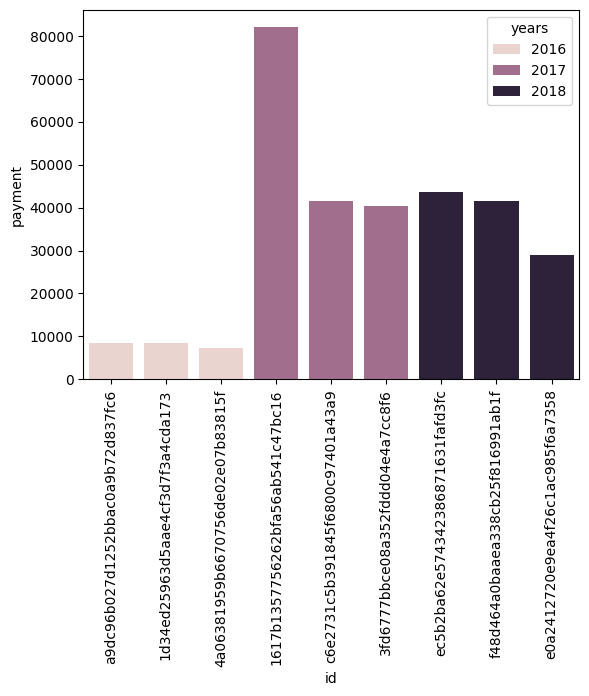

In [17]:
query="""
select years , customer_id, payment,d_rank from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)  
order by sum(payments.payment_value )desc) d_rank
from orders join payments
on payments.order_id= orders.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank<=3
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()